In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.tail as exp_tail

# Explore

In [4]:
np.random.seed(2024)

In [ ]:
dim = 1
n = 10000
dof = 100

scale = jnp.sqrt((dof - 2) / dof)
Xs = np.random.standard_t(df=dof, size=(n, dim)) * scale

In [28]:
Xs.mean(), Xs.std()

(Array(0.00619668, dtype=float32), Array(1.0359316, dtype=float32))

# Load

In [2]:
n = 500
d = 1
res_stats = pickle.load(open(f"../data/tail/stats_n{n}_d{d}.pkl", "rb"))

dof_ls = list(res_stats.keys())
dof_ls

[3, 5, 10, 20, 50, 100, 200]

In [3]:
tau = pickle.load(open(f"../data/tail/tau_d{d}.pkl", "rb"))
tau

{3: Array(2.2207792, dtype=float32),
 5: Array(1.8133168, dtype=float32),
 10: Array(1.6810317, dtype=float32),
 20: Array(1.652056, dtype=float32),
 50: Array(1.7523128, dtype=float32),
 100: Array(1.6422663, dtype=float32),
 200: Array(1.653837, dtype=float32)}

In [38]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}
nu_lb = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for dof in dof_ls:
        theta_new = eps0 * tau[dof]**0.5
        # theta_new = eps0 * res_stats[dof]["theta"] / 0.05
        
        res_stats_new[dof] = exp_utils.change_theta(res_stats_new[dof], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)

        # compute lower bound on dof so that KSD(Q, P) <= \theta + o(1)
        nu_lb[dof] = exp_tail.compute_nu_threshold(theta=theta_new, tau=tau[dof])
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    plot_df = {"dof": [], "nonsq_stat": [], "method": [], "rej": [], "dof_lb": []}
    for dof in dof_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[dof][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["dof"].extend([dof] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

            plot_df["dof_lb"].extend([nu_lb[dof]] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

In [39]:
for eps0 in eps0_ls:
    print(plot_df_ls[eps0].dof_lb.unique())
    # print(tau[dof]**0.5)

[4031.44018555 4031.44165039]
[62.9912529  62.99127579]
[0.25801232]


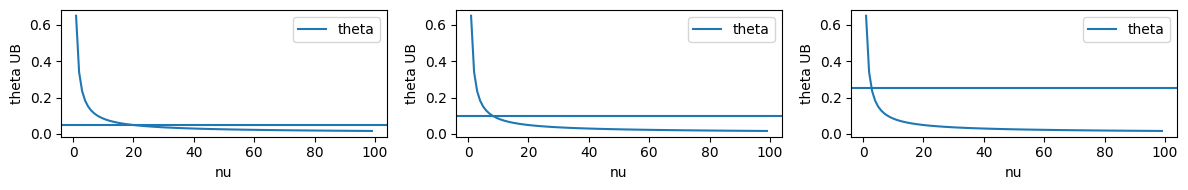

In [84]:
def bound(nu, B_pow, tau):
    Z_ub = 1/(2*jnp.pi)**0.5 * (1 + 1/nu)**0.5
    B = nu**B_pow
    term1 = (2*jnp.pi)**(-0.5) * (1 + 1/nu)**0.5 * (
        B**5 / (10 * nu)
        + B**3 / (6 * nu)
    )
    term2 = 1/(2*nu)
    # term2 = 0.
    res = term1 + term2
    return res * tau**0.5

_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 2))
nu_ls = jnp.arange(1, 100)
for i, eps0 in enumerate(eps0_ls):
    ax = axes[i]
    theta_ls = jax.vmap(lambda x: bound(x, 1/8, tau[dof]))(nu_ls)
    # ax.plot(nu_ls, theta_ls)
    # ax.axhline(eps0 * tau[dof]**0.5, label="theta")
    ax.plot(nu_ls, theta_ls / tau[dof]**0.5)
    ax.axhline(eps0, label="theta")
    ax.set_xlabel("nu")
    ax.set_ylabel("theta UB")
    ax.legend()
    
plt.tight_layout()

In [83]:
eps0 = eps0_ls[1]
print(jnp.where(theta_ls / tau[dof]**0.5 > eps0, nu_ls, 0))

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
1/(2*nu_ls) - ((1 + 1/nu_ls)**0.5 - 1)

Array([8.57864618e-02, 2.52550840e-02, 1.19661540e-02, 6.96599483e-03,
       4.55484539e-03, 3.20991129e-03, 2.38362700e-03, 1.83987617e-03,
       1.46302953e-03, 1.19118765e-03, 9.88647342e-04, 8.33671540e-04,
       7.12487847e-04, 6.15973026e-04, 5.37786633e-04, 4.73618507e-04,
       4.20184806e-04, 3.75377014e-04, 3.37462872e-04, 3.04961577e-04,
       2.76895240e-04, 2.52626836e-04, 2.31271610e-04, 2.12630257e-04,
       1.96117908e-04, 1.81483105e-04, 1.68394297e-04, 1.56709924e-04,
       1.46171078e-04, 1.36630610e-04, 1.28045678e-04, 1.20162964e-04,
       1.13144517e-04, 1.06559135e-04, 1.00524165e-04, 9.51820984e-05,
       9.00710002e-05, 8.54041427e-05, 8.10930505e-05, 7.72001222e-05,
       7.34440982e-05, 7.00214878e-05, 6.68708235e-05, 6.39073551e-05,
       6.10062853e-05, 5.84749505e-05, 5.59696928e-05, 5.36842272e-05,
       5.15030697e-05, 4.94811684e-05, 4.75952402e-05, 4.58592549e-05,
       4.40850854e-05, 4.24738973e-05, 4.10163775e-05, 3.94927338e-05,
      

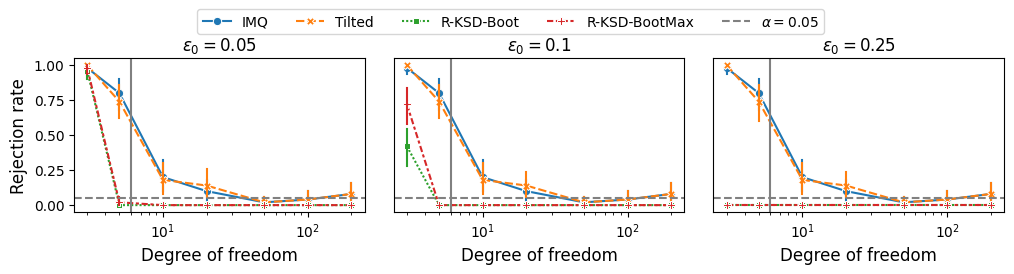

In [52]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    # ax.axvline(plot_df_ls[eps0].dof_lb.unique()[0], color="grey")
    ax.set_xlabel("Degree of freedom", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.4, 1.11, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

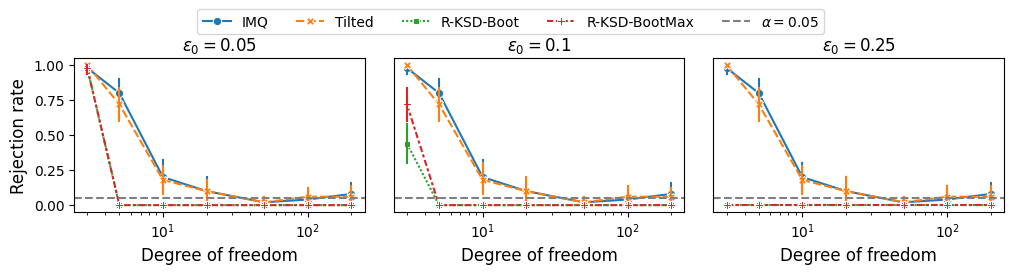

In [7]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Degree of freedom", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.4, 1.11, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [135]:
# show model and data densities

x_plot = jnp.linspace(-5., 5., 1001)
model_pdf = jax.scipy.stats.norm.pdf(x_plot)

den_df = {"x": [], "den": [], "dof": []}
for dof in [3, 10, 50, 100]:
    data_pdf = exp_tail.t_pdf_multivariate(x_plot.reshape((-1, 1)), df=dof).tolist()
    den_df["x"].extend(x_plot.tolist())
    den_df["den"].extend(data_pdf)
    den_df["dof"].extend([dof] * len(x_plot))
den_df = pd.DataFrame(den_df)

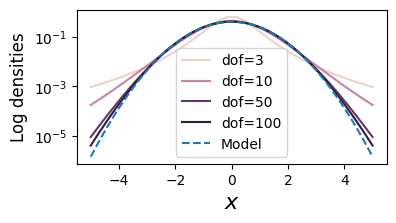

In [175]:
_, ax = plt.subplots(figsize=(4, 2))

# g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue="dof", legend="full")
g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue=np.log(den_df.dof), legend="full")
g2 = ax.plot(x_plot, model_pdf, color="C0", linestyle="--", label="Model")
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel("Log densities", fontsize=12)
ax.set_yscale("log")
ax.legend(handles=g1.get_legend().legend_handles + g2, labels=[f"dof={r}" for r in den_df.dof.unique().tolist()] + ["Model"])
# plt.savefig("../figs/robust/tail_den.pdf", bbox_inches="tight")